In [1]:
import sys
import os
import pickle

# Add the parent directory to sys.path
sys.path.append("/home/jovyan/video-storage/amit_files/image_background_remove_tool")

import torch
device = "cuda" if torch.cuda.is_available else "cpu"

In [2]:
from carvekit.ml.arch.tracerb7.efficientnet import EfficientEncoderB7
from carvekit.ml.wrap.tracer_b7 import TracerUniversalB7

In [3]:
model = TracerUniversalB7()

In [4]:
model = model.to(device)

In [5]:
triplet_first_image = "/home/jovyan/video-storage/amit_files/MTP_01/Vimeo_Triplet_Folder/second_image"
img_dir = os.listdir(triplet_first_image)

In [6]:
image_dir = [os.path.join(triplet_first_image, image) for image in img_dir]

In [7]:
import time
len(image_dir)

73193

In [8]:
start = time.time()
output = model(image_dir[:1])
print(time.time() - start)

/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0.8892064094543457


In [12]:
# # Save the list to a pickle file
# with open('model_outputs.pkl', 'wb') as file:
#     pickle.dump(output, file)


In [13]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

class TripletDataset(Dataset):
    def __init__(self, dir1, dir2,model = None, transform=None):
        self.dir1 = dir1
        self.dir2 = dir2
        self.transform = transform
        self.model = model.to(device)
        
        # Ensure directories contain the same number of images
        self.images1 = sorted(os.listdir(dir1))
        self.images2 = sorted(os.listdir(dir2))
        
        assert len(self.images1) == len(self.images2), "Both directories must contain the same number of images."

    def __len__(self):
        return len(self.images1)

    def __getitem__(self, idx):
        img1_path = os.path.join(self.dir1, self.images1[idx])
        img2_path = os.path.join(self.dir2, self.images2[idx])
        
        # Open images
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)
        img3 = model([img2_path])[0]
        # print(type(img1),type(img2),type(img3))
        
        # Apply any transformations
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        
        return img1, img2 ,img3


In [14]:
triplet_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.resize((img.size[0]//2,img.size[1]//2), resample=Image.LANCZOS)),  # Lanczos resampling
    transforms.ToTensor(),
])

In [15]:
# Paths
base_dir = '/home/jovyan/video-storage/amit_files/MTP_01/Triplet_folder/vimeo_triplet/sequences' 
output_dir_A = '/home/jovyan/video-storage/amit_files/MTP_01/Vimeo_Triplet_Folder/first_image' 
output_dir_B = '/home/jovyan/video-storage/amit_files/MTP_01/Vimeo_Triplet_Folder/second_image' 

In [16]:
Dataset = TripletDataset(output_dir_A,output_dir_B,model = model,transform = triplet_transform)

In [21]:
len(Dataset)

73193

In [18]:
print(Dataset[0][0].shape,Dataset[0][1].shape,Dataset[0][2].shape)

/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 128, 224]) torch.Size([3, 128, 224]) torch.Size([1, 128, 224])


In [36]:
def plot_image_grid(dataset, rows=10, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    
    for i in range(rows):
        for j in range(cols):
            if j == 2:
                img = np.asarray(dataset[i][j].permute(1,2,0))
                img = (img >= 0.5)
                axes[i, j].imshow(img)
            else:
                axes[i, j].imshow(dataset[i][j].permute(1,2,0))
            axes[i, j].axis('off')  
    
    plt.tight_layout()
    plt.show()



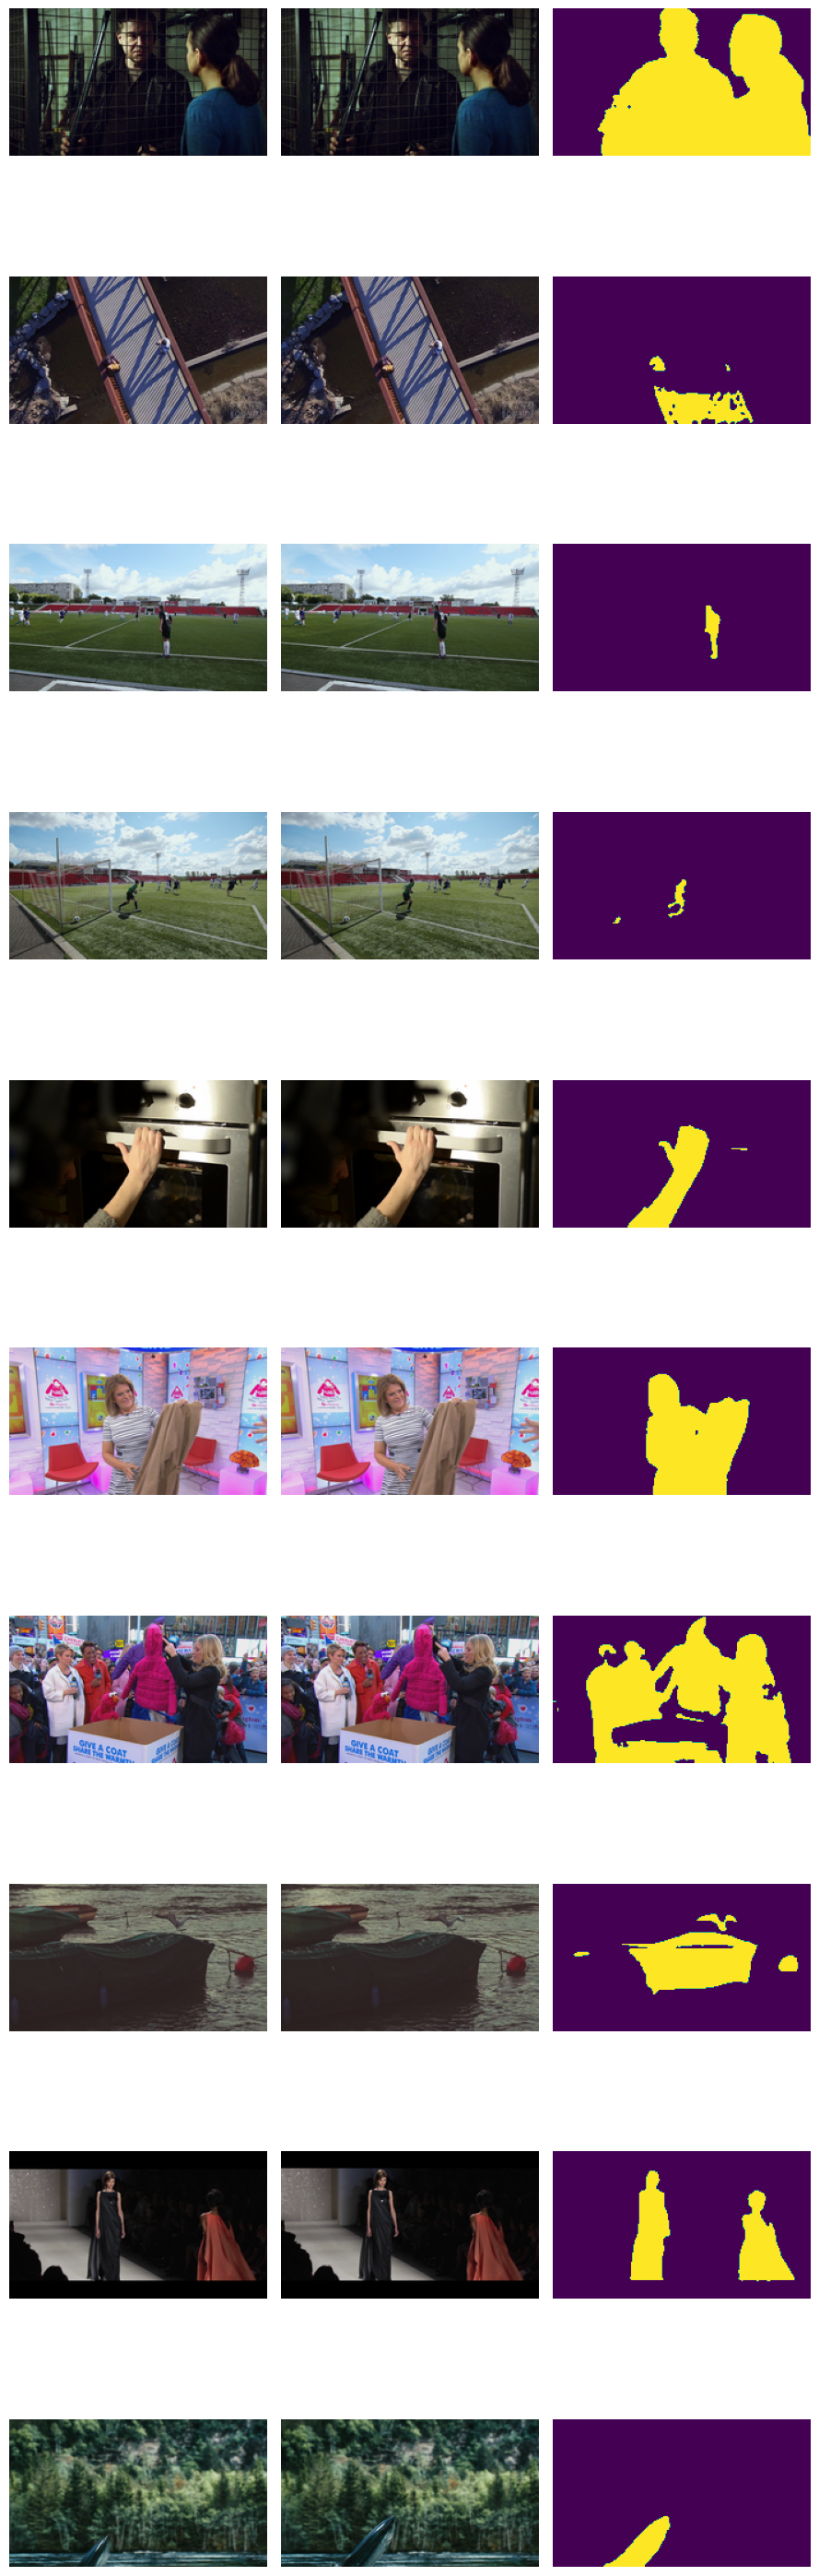

In [37]:
plot_image_grid(Dataset)